In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from math import floor
import os
import copy
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
import seaborn as sns

from src.data.data_processing import *
from src.data.data_fetching import *
from src.models.model_zoo import *
from src.models.predict_model import *
from src.models.train_model import *
from src.models.hyperparameter_tuning import *
from src.models.analyze_lstm_cell import *

In [2]:
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


# Evaluate Training on Individual ResOps Reservoirs

In [3]:
# Read R2 scores from training individual ResOPS reservoirs
r2_scores_df = pd.read_csv('report/results/resops_training/resops_individual_r2.csv', index_col=0)
r2_scores_df.index = r2_scores_df.index.astype(str) # change index type to str
r2_scores_df

,train,val,test
1754,0.616776,0.542443,0.397781
780,0.812543,0.640911,0.261094
1756,0.640635,0.485420,0.625418
393,0.764591,0.675054,0.726631
297,0.205251,0.155093,0.151003
...,...,...,...
753,0.388972,0.030416,0.303888
505,0.384544,0.548749,0.400114
7318,0.959340,0.952557,0.929671
1776,0.872272,0.737064,0.697465


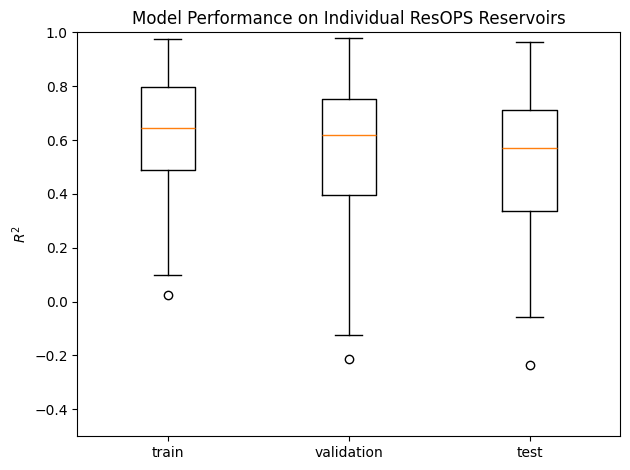

In [4]:
# Plot distribution of performance
fig, ax = plt.subplots()
bp = ax.boxplot(r2_scores_df, labels=['train', 'validation', 'test'])
ax.set_title('Model Performance on Individual ResOPS Reservoirs')
ax.set_ylabel('$R^2$')
plt.ylim(-0.5, 1)
plt.tight_layout()
plt.show()

There is a large variability in performance, and unsurprisingly, the median performance is decreasing over train, validation, and test.

## Is performance related to the degree of regulation?
Plot performance against reservoir mean(inflow) / max(storage) as well as std(inflow) / std(outflow)

In [5]:
# Read inflow/outflow/storage for all ResOps reservoirs
df_inflow = pd.read_csv("data/ResOpsUS/time_series_single_variable_table/DAILY_AV_INFLOW_CUMECS.csv", 
                        parse_dates=True, index_col=0, dtype=np.float32)
df_outflow = pd.read_csv("data/ResOpsUS/time_series_single_variable_table/DAILY_AV_OUTFLOW_CUMECS.csv", 
                         parse_dates=True, index_col=0, dtype=np.float32)
df_storage = pd.read_csv("data/ResOpsUS/time_series_single_variable_table/DAILY_AV_STORAGE_MCM.csv", 
                         parse_dates=True, index_col=0, dtype=np.float32)

In [6]:
# Calculate mean inflow / max storage metric
df_result = pd.concat([df_inflow.mean(skipna=True), 
                       df_inflow.median(skipna=True),
                       df_inflow.max(),
                       df_inflow.std(skipna=True),
                       df_outflow.mean(skipna=True),
                       df_outflow.median(skipna=True),
                       df_outflow.max(),
                       df_outflow.std(skipna=True),
                       df_storage.max()], axis=1, join='inner')
df_result.columns = ['mean_inflow', 'med_inflow', 'max_inflow', 'std_inflow', 
                     'mean_outflow', 'med_outflow', 'max_outflow', 'std_outflow', 
                     'max_storage']
# df_result['inflow_storage'] = df_result['mean_inflow'] / df_result['max_storage'] # mean inflow / max storage ratio
# df_result['inflow_outflow_std'] = df_result['std_inflow'] / df_result['std_outflow'] # std inflow / std outflow
df_result = df_result.dropna(axis=0) # remove rows with missing
df_result

,mean_inflow,med_inflow,max_inflow,std_inflow,mean_outflow,med_outflow,max_outflow,std_outflow,max_storage
1001,4.419854,0.283000,863.661987,19.111698,2.975682,0.227000,118.250999,9.217994,288.101013
1003,15.022496,1.982000,2078.452881,58.304733,14.654465,1.274000,591.226013,30.723732,281.072998
1006,33.187138,13.592000,2403.812988,77.436790,29.822630,2.350000,181.539001,39.114990,1704.770996
1007,11.411123,1.982000,1548.928955,45.397686,11.072395,1.048000,153.759995,22.744249,304.446014
1017,28.196121,14.059000,2980.343018,65.937279,28.084494,13.776000,167.834000,29.959730,553.226013
...,...,...,...,...,...,...,...,...,...
976,-0.121373,0.000000,175.156998,10.995893,0.050903,0.000000,11.327000,0.545414,239.998001
982,6.373040,0.850000,787.489990,25.823671,5.406381,0.566000,84.949997,12.086873,387.018005
987,22.491190,14.545000,407.053986,25.176218,22.434820,12.965000,320.477997,26.601582,364.475006
989,280.362610,104.772003,12594.462891,489.995361,270.817657,105.707001,2014.031982,366.046021,6193.534180


In [7]:
# Combine with model performance
df_result = df_result.join(other=r2_scores_df, how='inner')
df_result

,mean_inflow,med_inflow,max_inflow,std_inflow,mean_outflow,med_outflow,max_outflow,std_outflow,max_storage,train,val,test
1017,28.196121,14.059000,2980.343018,65.937279,28.084494,13.776000,167.834000,29.959730,553.226013,0.632672,0.684325,0.628673
1026,124.731316,64.690002,7628.545898,240.312531,118.351730,80.844002,2055.346924,134.028549,4681.919922,0.650935,0.555938,0.565325
1036,183.351807,113.706001,6513.997070,249.977036,174.091354,114.654999,1661.602051,173.091385,6802.357910,0.361174,0.344408,0.383323
1042,58.201374,31.658001,5986.455078,123.823402,54.375420,39.926998,1588.345947,56.211502,2501.490967,0.261352,0.064898,0.088852
1067,50.235088,13.011499,8751.732422,150.883362,45.832268,27.466999,303.556000,50.898769,3465.172119,0.385523,0.296983,0.466772
...,...,...,...,...,...,...,...,...,...,...,...,...
920,41.242645,43.414497,63.481998,17.920595,41.450428,44.428001,68.911003,17.602955,8.261000,0.972571,0.959876,0.778744
938,1.417140,1.176500,248.766006,5.622516,1.418812,0.170000,29.166000,2.186409,63.102001,0.550392,0.351002,0.249014
939,0.431045,0.299000,201.352997,4.194524,0.405882,0.113000,9.911000,0.794064,49.077000,0.546148,-0.214796,-3.621738
953,0.106396,0.022000,61.849998,1.775072,0.102358,0.024000,3.681000,0.417217,50.449001,0.242713,0.000127,0.059496


In [8]:
df_result.to_csv('report/results/resops_training/resops_attributes_r2.csv')

In [9]:
def lobf(x, y, ax):
    """Plot line of best fit"""
    #Find line of best fit
    a, b = np.polyfit(x, y, 1)
    #Add line of best fit to plot
    ax.plot(x, a*x+b, color='red')
    return

In [10]:
def correlate(x, y):
    """Return pearson correlation"""
    return stats.pearsonr(x, y)[0]

In [11]:
def correlate_pval(x, y, alt='two-sided', n_resamples=10000):
    """
    Return pval testing significance of correlation coefficient using permutation testing
    Params:
    x, y: data arrays to calculate correlation between
    alt: str, 'greater', 'less', or 'two-sided'. The alternative hypothesis
    n_resamples: int, number of permutations used to approximate null distribution
    Return:
    r - float, Pearson's correlation between x and y
    pvalue - p-value from permutation testing
    """
    # Calculate correlation between x and y and permuation test p-value
    res = stats.permutation_test((x, y), correlate, vectorized=False,
                        permutation_type='pairings',
                        alternative=alt,
                        n_resamples=n_resamples,
                        random_state=0)
    r, pvalue, null = res.statistic, res.pvalue, res.null_distribution
    return r, pvalue

c:\Users\mattc\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_hypotests.py:1590: RuntimeWarning: overflow encountered in double_scalars
  n_max = factorial(n_obs_sample)**n_samples
c:\Users\mattc\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_hypotests.py:1590: RuntimeWarning: overflow encountered in double_scalars
  n_max = factorial(n_obs_sample)**n_samples


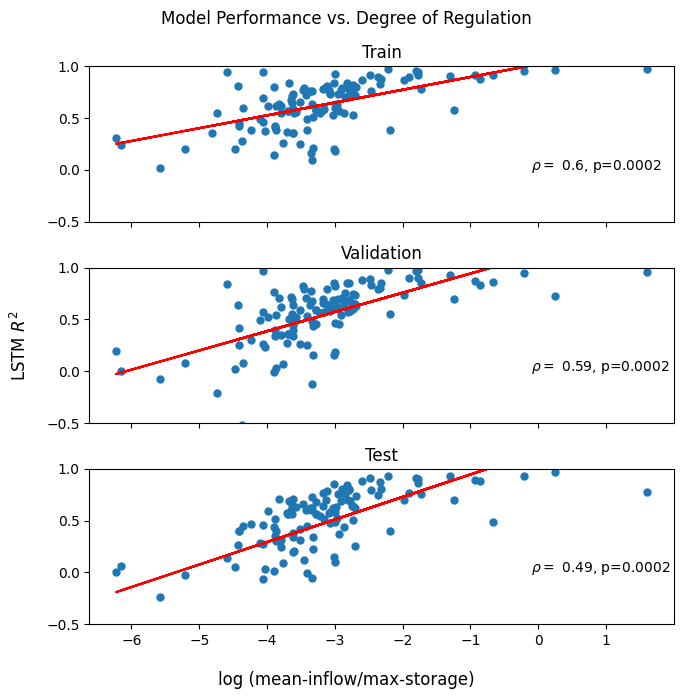

In [12]:
# Plot result
fig, axes = plt.subplots(nrows=3, figsize=(7, 7), sharex=True, sharey=True)
# log(mean inflow / max storage) ratio
# max storage is surrogate for capacity
x = np.log(df_result['mean_inflow'] / df_result['max_storage'])
# LSTM R2 performance
y_train, y_val, y_test = df_result['train'], df_result['val'], df_result['test']

axes[0].scatter(x, y_train, s=25)
axes[0].set_ylim(-0.5, 1)
axes[0].set_title('Train')
lobf(x, y_train, ax=axes[0]) # add line of best fit
# Add correlation and p-value
corr_train, pval_train = correlate_pval(x, y_train)
axes[0].text(-0.1, 0, r'$\rho=$'+f' {round(corr_train, 2)}, p={round(pval_train, 6)}')

axes[1].scatter(x, y_val, s=25)
axes[1].set_ylim(-0.5, 1)
axes[1].set_title('Validation')
lobf(x, y_val, ax=axes[1])
corr_val, pval_val = correlate_pval(x, y_val)
axes[1].text(-0.1, 0, r'$\rho=$'+f' {round(corr_val, 2)}, p={round(pval_val, 6)}')

# One outlying point is removed from the test set
axes[2].scatter(x.drop(index='1249'), y_test.drop(index='1249'), s=25)
axes[2].set_ylim(-0.5, 1)
axes[2].set_title('Test')
lobf(x.drop(index='1249'), y_test.drop(index='1249'), ax=axes[2])
corr_test, pval_test = correlate_pval(x.drop(index='1249'), y_test.drop(index='1249'))
axes[2].text(-0.1, 0, r'$\rho=$'+f' {round(corr_test, 2)}, p={round(pval_test, 6)}')

fig.suptitle('Model Performance vs. Degree of Regulation')
fig.supylabel('LSTM $R^2$')
fig.supxlabel('log (mean-inflow/max-storage)')
plt.tight_layout()
plt.show()

c:\Users\mattc\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_hypotests.py:1590: RuntimeWarning: overflow encountered in double_scalars
  n_max = factorial(n_obs_sample)**n_samples


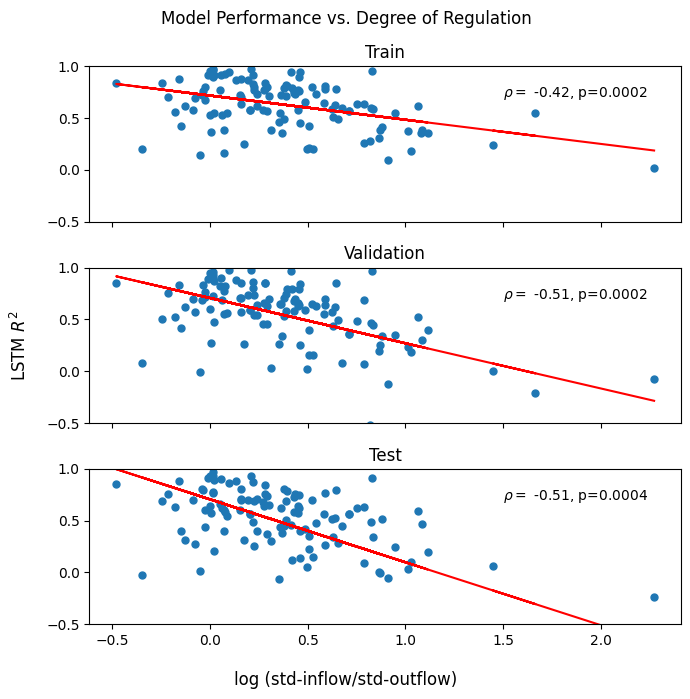

In [13]:
# Plot result
fig, axes = plt.subplots(nrows=3, figsize=(7, 7), sharex=True, sharey=True)
x = np.log(df_result['std_inflow'] / df_result['std_outflow'])
# LSTM R2 performance
y_train, y_val, y_test = df_result['train'], df_result['val'], df_result['test']

axes[0].scatter(x, y_train, s=25)
axes[0].set_ylim(-0.5, 1)
axes[0].set_title('Train')
lobf(x, y_train, ax=axes[0]) # add line of best fit
# Add correlation and p-value
corr_train, pval_train = correlate_pval(x, y_train)
axes[0].text(1.5, 0.7, r'$\rho=$'+f' {round(corr_train, 2)}, p={round(pval_train, 6)}')

axes[1].scatter(x, y_val, s=25)
axes[1].set_ylim(-0.5, 1)
axes[1].set_title('Validation')
lobf(x, y_val, ax=axes[1])
corr_val, pval_val = correlate_pval(x, y_val)
axes[1].text(1.5, 0.7, r'$\rho=$'+f' {round(corr_val, 2)}, p={round(pval_val, 6)}')

# One outlying point is removed from the test set
axes[2].scatter(x.drop(index='1249'), y_test.drop(index='1249'), s=25)
axes[2].set_ylim(-0.5, 1)
axes[2].set_title('Test')
lobf(x.drop(index='1249'), y_test.drop(index='1249'), ax=axes[2])
corr_test, pval_test = correlate_pval(x.drop(index='1249'), y_test.drop(index='1249'))
axes[2].text(1.5, 0.7, r'$\rho=$'+f' {round(corr_test, 2)}, p={round(pval_test, 6)}')

fig.suptitle('Model Performance vs. Degree of Regulation')
fig.supylabel('LSTM $R^2$')
fig.supxlabel('log (std-inflow/std-outflow)')
plt.tight_layout()
plt.show()

We find that the correlation between log(inflow/storage) and LSTM model performance (R2) is strong for training and validation, approximately r=0.6. The correlation coefficient is weaker in the test set, but as discussed more factors affect model performance further into the future such as changing reservoir policy. Additionally, at the level 0.05, the permutation test shows that each correlation is significantly greater than 0.

These results support the hypothesis that the degree of regulation adversely affects model performance.

To do:
- map of test performance
- compare resops linear performance, read turner for more benchmark ideas
- peak/regulartion metric
- pooled training on ResOPS (held out reservoirs)


### Appendix: Outlying Reservoir in Test Set

In [14]:
df_result[df_result['test'] < -20]

,mean_inflow,med_inflow,max_inflow,std_inflow,mean_outflow,med_outflow,max_outflow,std_outflow,max_storage,train,val,test
1249,0.126683,0.006,68.357002,1.109484,0.040948,0.0,13.535,0.376597,15.613,0.351834,-1.655672,-41.940881


Text(-4.9, -40, 'Reservoir 1249')

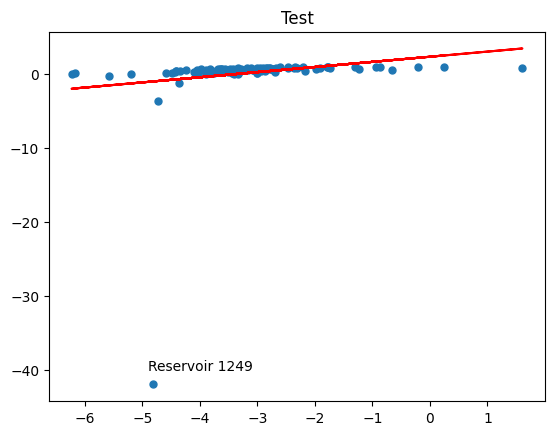

In [17]:
fig, axes = plt.subplots()
axes.scatter(np.log(df_result['mean_inflow'] / df_result['max_storage']), df_result['test'], s=25)
# axes.set_ylim(-0.5, 1)
axes.set_title('Test')
lobf(np.log(df_result['mean_inflow'] / df_result['max_storage']), df_result['test'], ax=axes)
axes.text(-4.9, -40, 'Reservoir 1249')